In [1]:
import sys
sys.path.append("..")

import os
project_root = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))

import pandas as pd
from training import TrainingManager, TrainingConfig
from envs.trading_env import MyTradingEnv

N_EPISODES=1_00

MAX_STEPS=8_000
LEARNING_RATE=0.05
DISCOUNT_FACTOR=0.9
EPSILON_START=1.0
EPSILON_END=0.01
EPSILON_DECAY=0.9998
EVAL_FREQUANCY=500
SAVE_FREQUANCY=1_000

TRAIN_VERSION="v1"

data_path = "../data/data_1h_2021.csv"
df1 = pd.read_csv(data_path, index_col=0, parse_dates=True, date_format="iso8601")
data_path = "../data/data_1h_2022.csv"
df2 = pd.read_csv(data_path, index_col=0, parse_dates=True, date_format="iso8601")
data_path = "../data/data_1h_2023.csv"
df3 = pd.read_csv(data_path, index_col=0, parse_dates=True, date_format="iso8601")

df = pd.concat([df1])

INITIAL_BALANCE = 1000.0
WINDOW_SIZE = 10
COMMISSION = 0.0001
SLIPPAGE = 0.0005
MAX_HOLDING_TIME = 60 * 24
HOLDING_THRESHOLD = 24
MAX_DRAWDOWN_THRESHOLD = 0.05
LAMBDA_DRAWDOWN = 0.1 # напрада в процентах
LAMBDA_HOLD = 0.028 # напрада в процентах
REWARD_SCALING=50.0 # напрада в процентах

In [2]:
def run_training(
    agent_type: str,
    df,
    project_root: str,
    env_params: dict,
    train_params: dict,
):

    if agent_type == "SARSA":
        from agents.classical.sarsa_agent import SarsaAgent

        agent = SarsaAgent()

    elif agent_type == "SARSA_Lambda":
        from agents.classical.sarsa_lambda_agent import SarsaLambdaAgent

        agent = SarsaLambdaAgent()

    elif agent_type == "QLearning":
        from agents.classical.qlearning_agent import QLearningAgent

        agent = QLearningAgent()

    elif agent_type == "Monte_Carlo":
        from agents.classical.monte_carlo_agent import MonteCarloAgent

        agent = MonteCarloAgent()

    else:
        raise ValueError(f"Unknown agent type: {agent_type}")

    env = MyTradingEnv(df=df, **env_params)

    config = TrainingConfig(
        agent_name=f"{agent_type}_{TRAIN_VERSION}",
        agent_type=agent_type,
        **train_params,
    )

    manager = TrainingManager(
        base_log_dir=os.path.join(project_root, "training_data/logs"),
        base_checkpoint_dir=os.path.join(project_root, "training_data/checkpoints"),
    )

    experiment_name = f"exp_{agent_type.lower()}_{TRAIN_VERSION}"
    return manager.train_agent(agent, env, config, experiment_name)

In [3]:
env_params = {
    "initial_balance": INITIAL_BALANCE,
    "window_size": WINDOW_SIZE,
    "commission": COMMISSION,
    "slippage": SLIPPAGE,
    "max_holding_time": MAX_HOLDING_TIME,
    "lambda_drawdown": LAMBDA_DRAWDOWN,
    "lambda_hold": LAMBDA_HOLD,
    "reward_scaling": REWARD_SCALING,
    "max_steps": MAX_STEPS,
}

train_params = {
    "n_episodes": N_EPISODES,
    "max_steps": MAX_STEPS,
    "learning_rate": LEARNING_RATE,
    "discount_factor": DISCOUNT_FACTOR,
    "epsilon_start": EPSILON_START,
    "epsilon_end": EPSILON_END,
    "epsilon_decay": EPSILON_DECAY,
    "eval_frequency": EVAL_FREQUANCY,
    "save_frequency": SAVE_FREQUANCY,
}

### Обучение QLearningAgent

In [4]:
results = run_training(
    agent_type="QLearning",
    df=df,
    project_root=project_root,
    env_params=env_params,
    train_params=train_params
)


Начало обучения: QLearning_v1
Эксперимент: exp_qlearning_v1
Эпизодов: 100
Learning rate: 0.05
Discount factor: 0.9

Агент сохранён: /mnt/d/Study/Code/ml/TradingAgentClassicRL/training_data/checkpoints/exp_qlearning_v1/final_agent.pkl

 Логи сохранены в: /mnt/d/Study/Code/ml/TradingAgentClassicRL/training_data/logs/exp_qlearning_v1

Обучение завершено!
Время обучения: 4.90 минут
Финальная награда: -12298.32
Размер Q-таблицы: 54 состояний



### Обучение MonteCarloAgent

In [5]:
train_params["max_steps"] = 500

results = run_training(
    agent_type="Monte_Carlo",
    df=df,
    project_root=project_root,
    env_params=env_params,
    train_params=train_params
)
train_params["max_steps"] = MAX_STEPS


Начало обучения: Monte_Carlo_v1
Эксперимент: exp_monte_carlo_v1
Эпизодов: 100
Learning rate: 0.05
Discount factor: 0.9

Monte Carlo агент сохранён: /mnt/d/Study/Code/ml/TradingAgentClassicRL/training_data/checkpoints/exp_monte_carlo_v1/final_agent.pkl

 Логи сохранены в: /mnt/d/Study/Code/ml/TradingAgentClassicRL/training_data/logs/exp_monte_carlo_v1

Обучение завершено!
Время обучения: 0.34 минут
Финальная награда: 330.40
Размер Q-таблицы: 40 состояний



### Обучение SarsaAgent

In [6]:
results = run_training(
    agent_type="SARSA",
    df=df,
    project_root=project_root,
    env_params=env_params,
    train_params=train_params
)


Начало обучения: SARSA_v1
Эксперимент: exp_sarsa_v1
Эпизодов: 100
Learning rate: 0.05
Discount factor: 0.9

SARSA(λ) агент сохранён: /mnt/d/Study/Code/ml/TradingAgentClassicRL/training_data/checkpoints/exp_sarsa_v1/final_agent.pkl

 Логи сохранены в: /mnt/d/Study/Code/ml/TradingAgentClassicRL/training_data/logs/exp_sarsa_v1

Обучение завершено!
Время обучения: 5.28 минут
Финальная награда: -7178.12
Размер Q-таблицы: 54 состояний



### Обучение SarsaLambdaAgent

In [7]:
train_params_lambda = {
    **train_params,
    "lambda_param": 0.8,
}

results = run_training(
    agent_type="SARSA_Lambda",
    df=df,
    project_root=project_root,
    env_params=env_params,
    train_params=train_params_lambda
)


Начало обучения: SARSA_Lambda_v1
Эксперимент: exp_sarsa_lambda_v1
Эпизодов: 100
Learning rate: 0.05
Discount factor: 0.9

SARSA(λ) агент сохранён: /mnt/d/Study/Code/ml/TradingAgentClassicRL/training_data/checkpoints/exp_sarsa_lambda_v1/final_agent.pkl

 Логи сохранены в: /mnt/d/Study/Code/ml/TradingAgentClassicRL/training_data/logs/exp_sarsa_lambda_v1

Обучение завершено!
Время обучения: 7.87 минут
Финальная награда: -11274.26
Размер Q-таблицы: 54 состояний



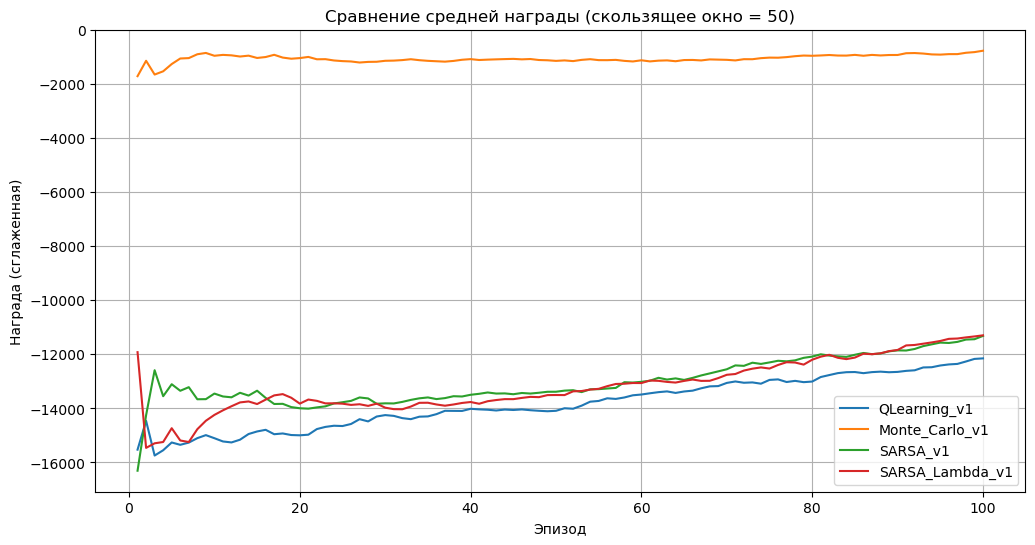

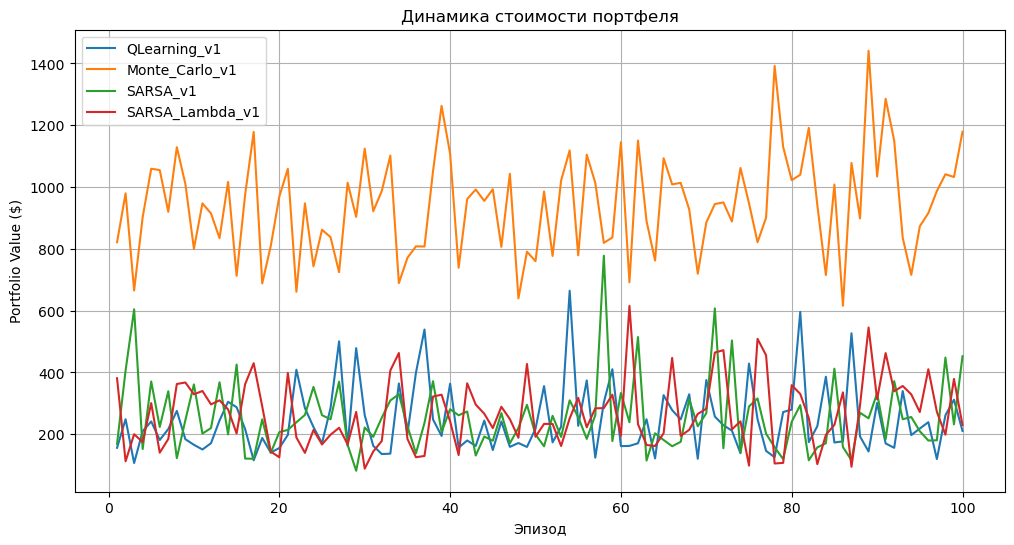

,agent,reward,portfolio_value,win_rate,n_trades,max_drawdown
99,QLearning_v1,-12298.32,211.07,40.82,1335,0.09
199,Monte_Carlo_v1,330.40,1178.99,56.96,79,0.04
299,SARSA_v1,-7178.12,452.58,43.67,1264,0.11
399,SARSA_Lambda_v1,-11274.26,230.09,43.35,1158,0.06


In [8]:

import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path

experiment_dirs = [
    f"../training_data/logs/exp_qlearning_{TRAIN_VERSION}",
    f"../training_data/logs/exp_monte_carlo_{TRAIN_VERSION}",
    f"../training_data/logs/exp_sarsa_{TRAIN_VERSION}",
    f"../training_data/logs/exp_sarsa_lambda_{TRAIN_VERSION}",
]

all_data = []
for exp_dir in experiment_dirs:
    exp_dir = Path(exp_dir)
    episodes_df = pd.read_csv(exp_dir / "episodes.csv")
    with open(exp_dir / "training_summary.json") as f:
        summary = json.load(f)
    agent_name = summary["config"]["agent_name"]
    episodes_df["agent"] = agent_name
    all_data.append(episodes_df)


df = pd.concat(all_data, ignore_index=True)

plt.figure(figsize=(12, 6))
for agent in df["agent"].unique():
    agent_data = df[df["agent"] == agent]
    smoothed = agent_data["reward"].rolling(window=50, min_periods=1).mean()
    plt.plot(agent_data["episode"], smoothed, label=agent)

plt.title("Сравнение средней награды (скользящее окно = 50)")
plt.xlabel("Эпизод")
plt.ylabel("Награда (сглаженная)")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 6))
for agent in df["agent"].unique():
    agent_data = df[df["agent"] == agent]
    plt.plot(agent_data["episode"], agent_data["portfolio_value"], label=agent)

plt.title("Динамика стоимости портфеля")
plt.xlabel("Эпизод")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()


final_metrics = df.groupby("agent").tail(1)[
    ["agent", "reward", "portfolio_value", "win_rate", "n_trades", "max_drawdown"]
]
display(final_metrics.round(2))